In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_theme(style='whitegrid', context='notebook', palette='muted')


## 1) Load the datasets
We read the provided CSV files and do a quick initial inspection (head, shape, columns).

In [50]:
confirmed_path = 'C:\\Tutedude_DS_Course\\Assignments\\Data\\covid19_Confirmed_dataset.csv'
deaths_path = 'C:\\Tutedude_DS_Course\\Assignments\\Data\\covid19_deaths_dataset.csv'
happiness_path = 'C:\\Tutedude_DS_Course\\Assignments\\Data\\worldwide_happiness_report.csv'

confirmed = pd.read_csv(confirmed_path)
deaths = pd.read_csv(deaths_path)
happiness = pd.read_csv(happiness_path)

print('Confirmed shape:', confirmed.shape)
print('Deaths shape:', deaths.shape)
print('Happiness shape:', happiness.shape)

display(confirmed.head())
display(deaths.head())
display(happiness.head())

Confirmed shape: (266, 104)
Deaths shape: (266, 104)
Happiness shape: (156, 9)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,609,634,663,678,712,726,736,750,766,773
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,717,723,723,731,738,738,743,743,743,745
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,24,25,25,25,25,26,27,27,27,27


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,36,40,42,43,47,50,57,58,60,64
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,26,27,27,27,27,28,28,30,30,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,392,402,407,415,419,425,432,437,444,450
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,37,37,37,40,40,40,40,41,42,42
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


## 2) Prepare COVID time-series data
These COVID files are likely in a wide format where each column after geographic columns is a date. We will melt them into a tidy long format: `Country/Region | Date | Cases` and `Country/Region | Date | Deaths`.

We handle common column name variations (e.g., `Country/Region` vs `Country_Region`).

In [51]:
def find_country_col(df):
    for c in ['Country/Region','Country_Region','Country','country','CountryName']:
        if c in df.columns:
            return c
    return df.columns[0]

c_col = find_country_col(confirmed)
d_col = find_country_col(deaths)
print('Confirmed country column:', c_col)
print('Deaths country column:', d_col)

def find_date_columns(df):
    date_cols = []
    for col in df.columns:
        try:
            if col in ['Province/State','Province_State','Lat','Long','Latitude','Longitude','Province','Admin2']:
                continue
            pd.to_datetime(col)
            date_cols.append(col)
        except Exception:
            pass
    return date_cols

confirmed_date_cols = find_date_columns(confirmed)
deaths_date_cols = find_date_columns(deaths)
print('Number of date columns in confirmed:', len(confirmed_date_cols))
print('Number of date columns in deaths:', len(deaths_date_cols))

def melt_covid(df, value_name):
    ccol = find_country_col(df)
    date_cols = find_date_columns(df)
    id_vars = [c for c in df.columns if c not in date_cols]
    if len(date_cols) == 0:
        raise ValueError('No date-like columns found for melting.')
    long = df.melt(id_vars=id_vars, value_vars=date_cols, var_name='Date', value_name=value_name)
    if 'Province/State' in long.columns and 'Province_State' not in long.columns:
        long = long.rename(columns={'Province/State':'Province_State'})
    long = long.rename(columns={ccol: 'Country_Region'})
    # long['Date'] = pd.to_datetime(long['Date'])
    long['Date'] = pd.to_datetime(long['Date'], format='%m/%d/%y')
    return long

try:
    confirmed_long = melt_covid(confirmed, 'Confirmed')
    deaths_long = melt_covid(deaths, 'Deaths')
    print('Confirmed long shape:', confirmed_long.shape)
    print('Deaths long shape:', deaths_long.shape)
    display(confirmed_long.head())
except Exception as e:
    print('Could not melt automatically:', e)
    print('Confirmed columns:', confirmed.columns.tolist()[:20])
    print('Deaths columns:', deaths.columns.tolist()[:20])

Confirmed country column: Country/Region
Deaths country column: Country/Region
Number of date columns in confirmed: 100
Number of date columns in deaths: 100
Confirmed long shape: (26600, 6)
Deaths long shape: (26600, 6)


,Province_State,Country_Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0


## 3) Aggregate COVID totals per country
We compute the latest total confirmed cases and deaths per country (take maximum date available).

In [52]:
def country_latest_totals(long_df, value_col):
    grp = long_df.groupby(['Country_Region','Date'])[value_col].sum().reset_index()
    idx = grp.groupby('Country_Region')['Date'].idxmax()
    latest = grp.loc[idx].set_index('Country_Region')
    latest = latest.rename(columns={value_col: f'Total_{value_col}'})
    return latest[[f'Total_{value_col}']]

try:
    confirmed_latest = country_latest_totals(confirmed_long, 'Confirmed')
    deaths_latest = country_latest_totals(deaths_long, 'Deaths')
    covid_totals = confirmed_latest.join(deaths_latest, how='outer').fillna(0)
    covid_totals['Total_Deaths'] = covid_totals['Total_Deaths'].astype(int)
    covid_totals['Total_Confirmed'] = covid_totals['Total_Confirmed'].astype(int)
    display(covid_totals.sort_values('Total_Confirmed', ascending=False).head(10))
except Exception as e:
    print('Aggregation failed:', e)

,Total_Confirmed,Total_Deaths
Country_Region,,
US,1069424,62996
Spain,213435,24543
Italy,205463,27967
United Kingdom,172481,26842
France,167299,24410
Germany,163009,6623
Turkey,120204,3174
Russia,106498,1073
Iran,94640,6028


## 4) Clean and merge with Worldwide Happiness dataset
We attempt to merge the COVID totals with the happiness dataset by country name. Country names may differ; we'll perform a conservative join and show mismatches for manual review.

In [53]:
print('Happiness columns:', happiness.columns.tolist())

if 'Country name' in happiness.columns:
    h_country_col = 'Country name'
elif 'Country' in happiness.columns:
    h_country_col = 'Country'
else:
    h_country_col = happiness.columns[0]

print('Using happiness country column:', h_country_col)

covid_totals = covid_totals.reset_index().rename(columns={'index':'Country_Region'})
covid_totals['Country_key'] = covid_totals['Country_Region'].str.strip().str.lower()
happiness['Country_key'] = happiness[h_country_col].astype(str).str.strip().str.lower()

merged = happiness.merge(covid_totals[['Country_key','Total_Confirmed','Total_Deaths']], on='Country_key', how='left')

missing_covid = merged[merged['Total_Confirmed'].isna()][[h_country_col]].head(15)
print('Sample countries in happiness dataset missing covid totals (first 15):')
display(missing_covid)

display(merged[[h_country_col,'Total_Confirmed','Total_Deaths']].head(10))

Happiness columns: ['Overall rank', 'Country or region', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']
Using happiness country column: Overall rank
Sample countries in happiness dataset missing covid totals (first 15):
Sample countries in happiness dataset missing covid totals (first 15):


,Overall rank
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


,Overall rank,Total_Confirmed,Total_Deaths
0,1,NaN,NaN
1,2,NaN,NaN
2,3,NaN,NaN
3,4,NaN,NaN
4,5,NaN,NaN
5,6,NaN,NaN
6,7,NaN,NaN
7,8,NaN,NaN
8,9,NaN,NaN
9,10,NaN,NaN


## 5) Exploratory analysis and visualizations
We create a few plots: top countries by confirmed cases and deaths, scatter plots showing relationship between happiness score and COVID totals, and a correlation heatmap.

Using score column: Score


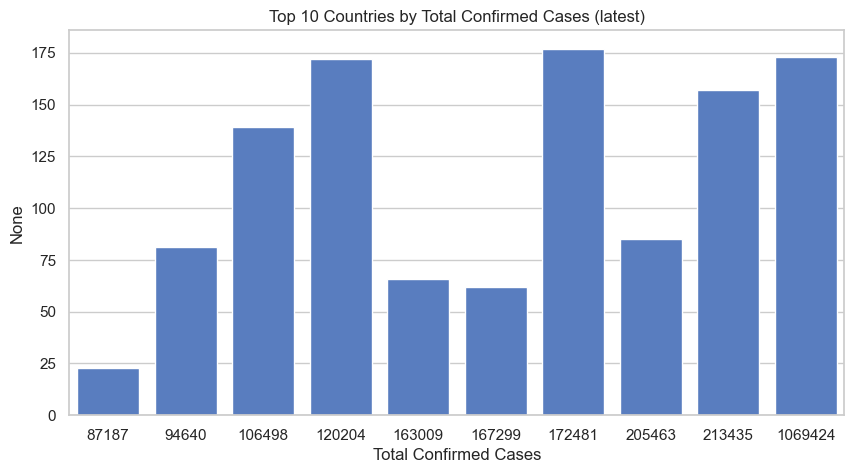

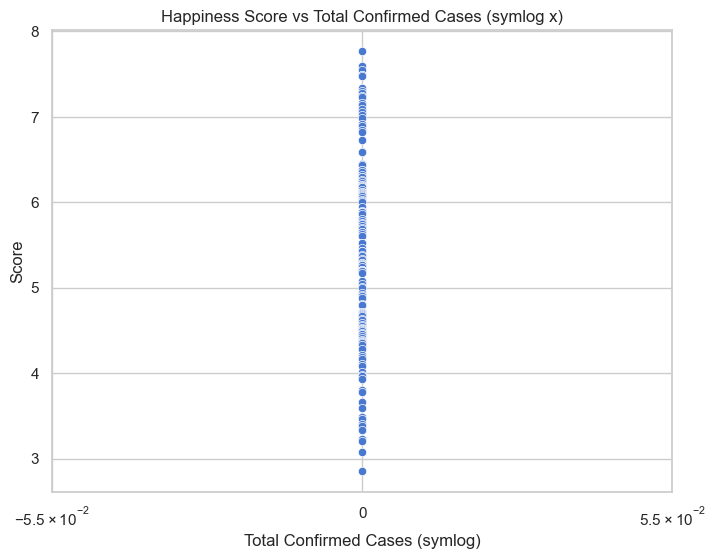

In [54]:
merged['Total_Confirmed'] = merged['Total_Confirmed'].fillna(0).astype(float)
merged['Total_Deaths'] = merged['Total_Deaths'].fillna(0).astype(float)

score_col = None
for c in merged.columns:
    if 'ladder' in c.lower() or 'happiness' in c.lower() or 'score' in c.lower():
        score_col = c
        break
print('Using score column:', score_col)

try:
    top_confirmed = covid_totals.sort_values('Total_Confirmed', ascending=False).head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_confirmed['Total_Confirmed'], y=top_confirmed.index)
    plt.title('Top 10 Countries by Total Confirmed Cases (latest)')
    plt.xlabel('Total Confirmed Cases')
    plt.show()
except Exception as e:
    print('Could not plot top confirmed:', e)

if score_col is not None:
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=merged, x='Total_Confirmed', y=score_col)
    plt.xscale('symlog')
    plt.title('Happiness Score vs Total Confirmed Cases (symlog x)')
    plt.xlabel('Total Confirmed Cases (symlog)')
    plt.ylabel(score_col)
    plt.show()
else:
    print('No happiness score column detected automatically. Please inspect merged.columns to pick the right one.')

## 6) Correlation matrix (numeric columns)
Compute correlations between numeric columns in the merged dataset and show a heatmap.

,Total_Confirmed,Total_Deaths
count,156.0,156.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


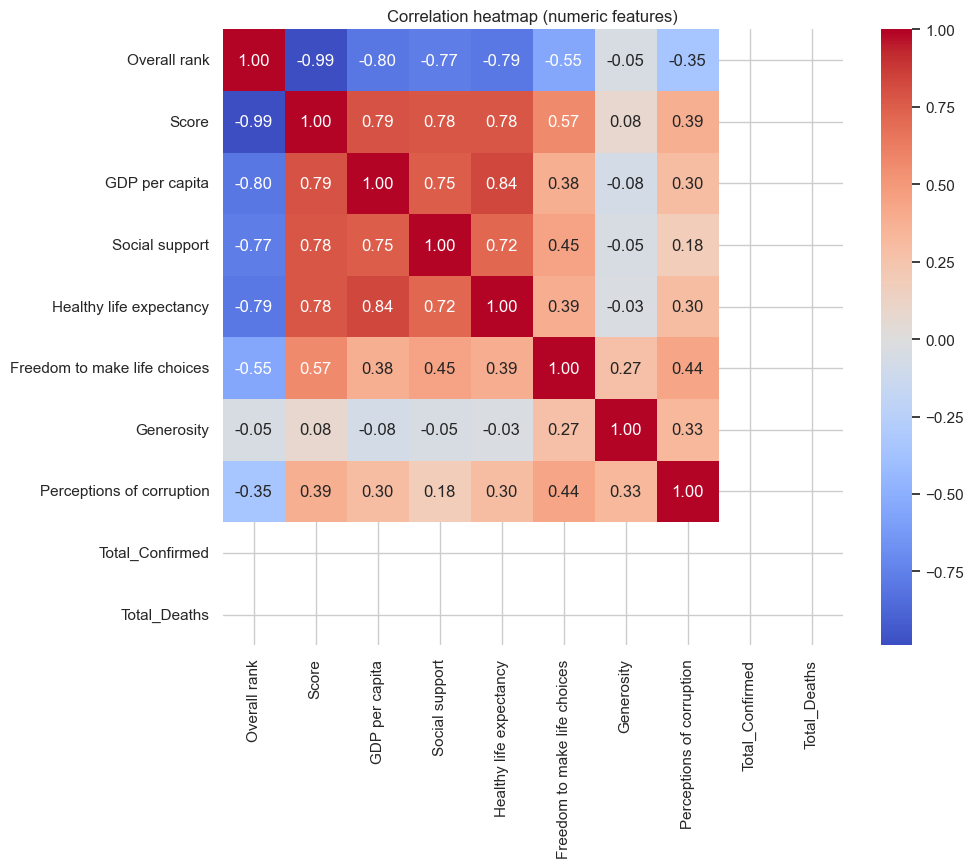

In [55]:
num = merged.select_dtypes(include=[np.number]).copy()
if 'Total_Confirmed' in num.columns and 'Total_Deaths' in num.columns:
    display(num[['Total_Confirmed','Total_Deaths']].describe())

corr = num.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation heatmap (numeric features)')
plt.show()

## 7) Observations and next steps
- Normalize case/death totals by population for fairer comparisons (requires population data).
- Use rolling averages on daily time series for trend analysis.
- Explore temporal correlations (e.g., happiness before/after pandemic peaks).

### Save the merged dataset (optional)

In [56]:
merged.to_csv('C:\\Tutedude_DS_Course\\Assignments\\Data\\merged_happiness_covid_totals.csv', index=False)
print('Saved merged file to C:\\Tutedude_DS_Course\\Assignments\\Data\\merged_happiness_covid_totals.csv')

Saved merged file to C:\Tutedude_DS_Course\Assignments\Data\merged_happiness_covid_totals.csv
